In [34]:
from keras import __version__
import numpy as np
from keras.models import model_from_json, Model, Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from keras import optimizers
from sklearn.model_selection import train_test_split
import keras
from tempfile import TemporaryFile
import csv
from sklearn.neighbors import KDTree, NearestNeighbors
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def load_model(weights_path, json_path):
    json_file = open('model_files/' + json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights('model_files/' + weights_path)
    print("Loaded model from disk")
    return loaded_model

def get_clothing_vector_model(weights_path, json_path):
    loaded_model = load_model(weights_path, json_path)
    loaded_model.layers.pop() # Get rid of the classification layer
    last = loaded_model.layers[-1].output
    model = Model(loaded_model.input, last)
    return model

def image_preprocess(img_path):
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)

    # our input image is now represented as a NumPy array of shape
    # (inputShape[0], inputShape[1], 3) however we need to expand the
    # dimension by making the shape (1, inputShape[0], inputShape[1], 3)
    # so we can pass it through thenetwork
    image = np.expand_dims(image, axis=0)

    # pre-process the image using the appropriate function based on the
    # model that has been loaded (i.e., mean subtraction, scaling, etc.)
    image = preprocess_input(image)
    return image

def get_classier_prediction(clothing_classifier, img_path):
    clothes_labels = ['dresses', 'handbags', 'hats', 'jackets', 'jeans', 
                      'jewelry', 'shorts', 'skirts', 'sunglasses', 'sweaters', 
                      'sweatshirts', 'womens-outerwear', 'womens-pants', 'womens-shoes', 'womens-tops']
    img = image_preprocess(img_path)
    preds = clothing_classifier.predict(img)[0]
    preds_labels = list(zip(clothes_labels, preds))
    preds_labels.sort(key=lambda p: p[1], reverse=True)
    return preds_labels

In [3]:
clothing_classifier_weights_path = 'inceptionv3_clothing_expanded_classifier.h5'
clothing_classifier_json_path = 'incep_filter_clothing_expanded_classifier.json'
clothing_classifier = load_model(clothing_classifier_weights_path, clothing_classifier_json_path)
clothing_classifier.summary()

Loaded model from disk
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_234 (Conv2D)              (None, None, None, 32 864         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_233 (BatchNo (None, None, None, 32 96          conv2d_234[0][0]                 
____________________________________________________________________________________________________
activation_233 (Activation)      (None, None, None, 32 0           batch_normalization_233[0][0]    
____________________________________________________________________

In [4]:
jeans_img_path = 'data-all/validation/jeans/482888849.jpg'
dress_img_path = 'data-all/validation/dresses/535993294.jpg'
jackets_img_path = 'data-all/validation/jackets/614521319.jpg'
jackets_img_path2 = 'data-all/validation/jackets/614763686.jpg'
sunglasses_img_path = 'data-all/validation/sunglasses/655241570.jpg'
dog_img_path = 'data-pets/train/dogs/dog.0.jpg'
get_classier_prediction(clothing_classifier, jeans_img_path)

[('jeans', 0.9994086),
 ('womens-pants', 0.00057119632),
 ('skirts', 9.8396049e-06),
 ('shorts', 5.1550901e-06),
 ('womens-shoes', 1.5977403e-06),
 ('dresses', 1.3391239e-06),
 ('sunglasses', 1.1239362e-06),
 ('handbags', 4.7018787e-07),
 ('womens-tops', 2.4409965e-07),
 ('jackets', 1.8252952e-07),
 ('sweaters', 1.2994336e-07),
 ('womens-outerwear', 1.1318394e-07),
 ('sweatshirts', 6.9145734e-08),
 ('jewelry', 2.7152957e-08),
 ('hats', 1.3843318e-08)]

In [5]:
classifier_vector_model = get_clothing_vector_model(clothing_classifier_weights_path, clothing_classifier_json_path)
img_jacket = image_preprocess(jackets_img_path)
img_jacket2 = image_preprocess(jackets_img_path2)
img_jeans = image_preprocess(jeans_img_path)
img_dress = image_preprocess(dress_img_path)
img_dog = image_preprocess(dog_img_path)

jacket_feat = classifier_vector_model.predict(img_jacket)
jacket_feat2 = classifier_vector_model.predict(img_jacket2)
jeans_feat = classifier_vector_model.predict(img_jeans)
dress_feat = classifier_vector_model.predict(img_dress)
dog_feat = classifier_vector_model.predict(img_dog)

jacket_feat

Loaded model from disk


array([[ 0.48110133,  1.57449007,  0.03476679, ...,  1.22023487,
         0.35871762,  0.71462518]], dtype=float32)

In [ ]:
# compare cosine similarities
print('2 jackets: ', cosine_similarity(jacket_feat, jacket_feat2))
print('jeans and dress: ', cosine_similarity(jeans_feat, dress_feat))
print('jeans and dog: ', cosine_similarity(jeans_feat, dog_feat))

In [ ]:
jacket_feat.shape # (1, 1024)

## Skipgrams Model

In [24]:
def save_product_features(model, product_file, img_dir, output_file):
    products = []
    print('Reading file ', product_file)
    with open(product_file, 'r') as f:
        for i, line in enumerate(f.readlines()[:]):
            if i % 50 == 0:
                print('Processing product ', i)
            try:
                l = line.split('\t')
                product_id = l[0]
                product_img_path = img_dir + product_id + '.jpg' 
                product_img = image_preprocess(product_img_path)
                product_feat = model.predict(product_img)
    
                products.append([product_id] + product_feat[0].tolist())
            except Exception as e:
                print(e)
                
    print('Saving products to ', output_file)
    with open(output_file, 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        for p in products:
            writer.writerow(p)
            f.flush()
    return products

def make_product_X_y(product_to_features, product1_id, product2_id, product3_id, product4_id):
    product1_feat = product_to_features[product1_id]
    product2_feat = product_to_features[product2_id]
    product3_feat = product_to_features[product3_id]
    product4_feat = product_to_features[product4_id]

    merged_feat = np.concatenate((product1_feat, product2_feat, product3_feat), axis=1)
    return merged_feat, product4_feat
    
def make_product_permutation_generator(outfit_permutations_file, product_to_features, batch_size):
    while True:
        with open(outfit_permutations_file, 'r') as f:
            curr_batch_X = []
            curr_batch_y = []
            for line in f:
                if len(curr_batch_X) == batch_size:
                    curr_batch_X = []
                    curr_batch_y = []
                    
                l = line.split()
                product1_id = l[2]
                product2_id = l[5]
                product3_id = l[8]
                product4_id = l[11]
                merged_feat, y_feat = make_product_X_y(product_to_features, product1_id, product2_id, 
                                                       product3_id, product4_id)
                curr_batch_X.append(merged_feat)
                curr_batch_y.append(y_feat)
                if len(curr_batch_X) == batch_size:
                    yield (np.array(curr_batch_X), np.array(curr_batch_y))


def get_product_to_features(product_feats_file):
    product_to_feats = {}
    with open(product_feats_file, 'r') as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter='\t')
        for row in tsvreader:
            product_id = row[0]
            feats = np.array([[float(n) for n in row[1:]]])
            product_to_feats[product_id] = feats
    return product_to_feats

In [ ]:
# Run one time to save product weights
# save_product_features(classifier_vector_model, 'data-outfits/outfit_products.tsv', 
#                       'data-outfits/images/', 'data-outfits/outfit_product_features.tsv')

In [10]:
product_feats_file = 'data-outfits/outfit_product_features.tsv'
outfit_permutations_file = 'data-outfits/outfit_permutations.tsv'
prods_to_feats = get_product_to_features(product_feats_file)
prods_to_feats['615752261']

array([[ 0.42040107,  1.48408139,  0.11978239, ...,  2.25705886,
         0.37974471,  0.94305986]])

In [ ]:
# np.array(X).shape # (400, 1, 2048)

In [28]:
def make_skipgrams_clothing_model():
    seq = Sequential()
    seq.add(Dense(1024, input_shape=(1,3072), activation='relu', name='fc1'))
    seq.add(Dropout(0.3))
    seq.add(Dense(256, activation='relu', name='fc2'))
    seq.add(Dropout(0.2))
    seq.add(Dense(1024, activation='linear', name='fc_final'))
    #seq.compile(loss="mean_squared_error", optimizer=optimizers.RMSprop(lr=0.00001), metrics=['mae'])
    seq.compile(loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.001), metrics=['mae'])
    return seq

In [30]:
def fit_save_skipgram_clothing_model(weights_file, json_file):
    batch_size = 1024
    nb_train_samples = 500000
    nb_val_samples = 200000
    model = make_skipgrams_clothing_model()
    train_outfit_permutations_file = 'data-outfits/outfit_permutations_train.tsv'
    val_outfit_permutations_file = 'data-outfits/outfit_permutations_val.tsv'
    train_generator = make_product_permutation_generator(train_outfit_permutations_file, 
                                                         prods_to_feats, batch_size)
    validation_generator = make_product_permutation_generator(val_outfit_permutations_file, 
                                                         prods_to_feats, batch_size)
    model.fit_generator(generator=train_generator, 
                        validation_data=validation_generator,
                        epochs=70, 
                        steps_per_epoch=nb_train_samples//batch_size,
                        validation_steps=nb_val_samples//batch_size)
    model.save('model_files/' + weights_file)
    model_json = model.to_json()
    with open('model_files/' + json_file, 'w') as json_file:
        json_file.write(model_json)
    print('Saved skipgrams models')
    return model

skipgram_model_weights_file = 'outfit_skipgram_model_weights.h5'
skipgram_model_json_file = 'outfit_skipgram_model.json'
fit_save_skipgram_clothing_model(skipgram_model_weights_file, skipgram_model_json_file)

Epoch 1/70
488/488 [==============================] - 26s - loss: 6.4798 - mean_absolute_error: 1.5737 - acc: 0.2470 - val_loss: 3.0892 - val_mean_absolute_error: 1.0031 - val_acc: 0.9962
Epoch 2/70
488/488 [==============================] - 25s - loss: 3.4213 - mean_absolute_error: 1.1856 - acc: 0.7291 - val_loss: 2.4384 - val_mean_absolute_error: 0.8026 - val_acc: 0.9962
Epoch 3/70
488/488 [==============================] - 25s - loss: 2.9454 - mean_absolute_error: 1.0720 - acc: 0.8468 - val_loss: 2.2579 - val_mean_absolute_error: 0.7679 - val_acc: 0.9962
Epoch 4/70
488/488 [==============================] - 26s - loss: 2.6949 - mean_absolute_error: 1.0136 - acc: 0.8965 - val_loss: 2.1171 - val_mean_absolute_error: 0.7465 - val_acc: 0.9962
Epoch 5/70
488/488 [==============================] - 25s - loss: 2.5018 - mean_absolute_error: 0.9700 - acc: 0.9253 - val_loss: 1.9968 - val_mean_absolute_error: 0.7285 - val_acc: 0.9962
Epoch 6/70
488/488 [==============================] - 25s - 

488/488 [==============================] - 25s - loss: 1.8340 - mean_absolute_error: 0.7639 - acc: 0.9957 - val_loss: 1.6984 - val_mean_absolute_error: 0.6620 - val_acc: 0.9962
Epoch 45/70
488/488 [==============================] - 25s - loss: 1.8322 - mean_absolute_error: 0.7630 - acc: 0.9957 - val_loss: 1.7307 - val_mean_absolute_error: 0.6632 - val_acc: 0.9962
Epoch 46/70
488/488 [==============================] - 25s - loss: 1.8289 - mean_absolute_error: 0.7618 - acc: 0.9959 - val_loss: 1.7211 - val_mean_absolute_error: 0.6623 - val_acc: 0.9962
Epoch 47/70
488/488 [==============================] - 25s - loss: 1.8270 - mean_absolute_error: 0.7608 - acc: 0.9959 - val_loss: 1.7112 - val_mean_absolute_error: 0.6621 - val_acc: 0.9962
Epoch 48/70
488/488 [==============================] - 25s - loss: 1.8248 - mean_absolute_error: 0.7599 - acc: 0.9959 - val_loss: 1.7302 - val_mean_absolute_error: 0.6630 - val_acc: 0.9962
Epoch 49/70
488/488 [==============================] - 25s - loss: 

In [31]:
# loss: 1.7930 - mean_absolute_error: 0.7442 - acc: 0.9962 - val_loss: 1.6994 - val_mean_absolute_error: 0.6589 - val_acc: 0.9962
clothing_skipgrams_model = load_model(skipgram_model_weights_file, skipgram_model_json_file)

Loaded model from disk


In [32]:
merged_feat_test, y_feat_actual = make_product_X_y(prods_to_feats, '462428872', '624181030', '531821593', '636805443')
# Actual Output
y_feat_actual

array([[ 0.09645113,  1.02082992,  0.18637043, ...,  1.66395879,
         0.03800734,  0.90601701]])

In [33]:
# Predicted Output
clothing_skipgrams_model.predict(np.array([merged_feat_test]))

array([[[ 0.22776897,  1.89924169,  0.31686571, ...,  2.56964874,
          0.83098793,  1.38709962]]], dtype=float32)

In [59]:
def display_product_images(product_ids):
    image_count = len(product_ids)
    fig, ax = plt.subplots(1, image_count, figsize=(image_count*5, 4))
    
    for i, product_id in enumerate(product_ids):
        image_file = 'data-outfits/images/' + product_id + '.jpg'
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
        ax[i].imshow(image, interpolation='nearest')
        ax[i].axis("off")
    plt.show()
    
def get_prod_feat_list():
    index_to_prod = {}
    prod_features = []
    for i, prod_feat in enumerate(prods_to_feats.items()):
        prod_id, feat = prod_feat
        index_to_prod[i] = prod_id
        prod_features.append(feat[0])
    return index_to_prod, np.array(prod_features)

index_to_prod, prod_features = get_prod_feat_list()
print('Making Nearest Neighbors ...')
#neighbors_model = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute')
neighbors_model = NearestNeighbors(n_neighbors=20, metric='euclidean', algorithm='auto')
neighbors_model.fit(prod_features)

Making Nearest Neighbors ...


NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=1.0)

In [60]:
np.array(prod_features[:3])

array([[ 0.        ,  5.85957146,  1.24812102, ...,  6.95872259,
         1.77266467,  3.18993473],
       [ 0.38827777,  3.8499105 ,  0.56135225, ...,  5.08135939,
         1.19380879,  2.65321469],
       [ 0.53009707,  3.31409311,  0.47977686, ...,  5.19207239,
         2.10588574,  2.59770107]])

In [61]:
neighbors_model.kneighbors(prod_features[:3], 5, return_distance=False)

array([[    0, 11749, 10494,  1011,  2665],
       [    1,  4089,  6182,  7430, 17610],
       [    2,  9439, 16460,   260, 14908]])

Input & Output Products: ['624551126', '506683222', '637575236', '380490225']


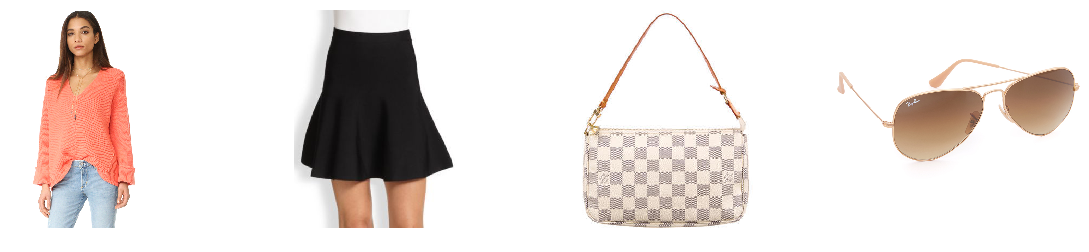

[[ 0.35232067  2.98845124  0.34664223 ...,  3.93553519  1.25853336
   2.12173939]]
Input & Output Products: ['645667402', '641247466', '511047164', '642818486']


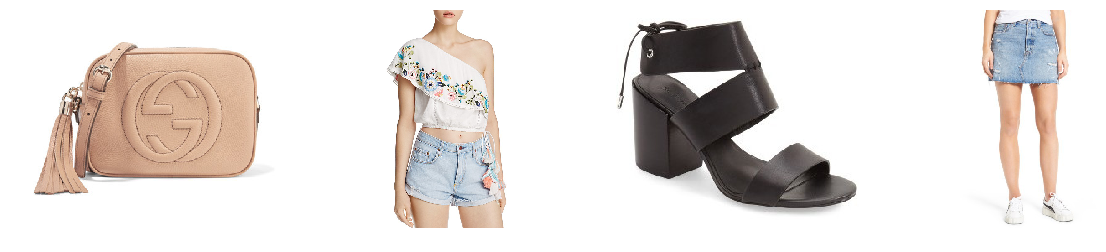

[[ 0.28442797  2.44150686  0.37915593 ...,  3.41941905  1.06359231
   1.82246697]]
Input & Output Products: ['542097641', '523023112', '543099844', '513851859']


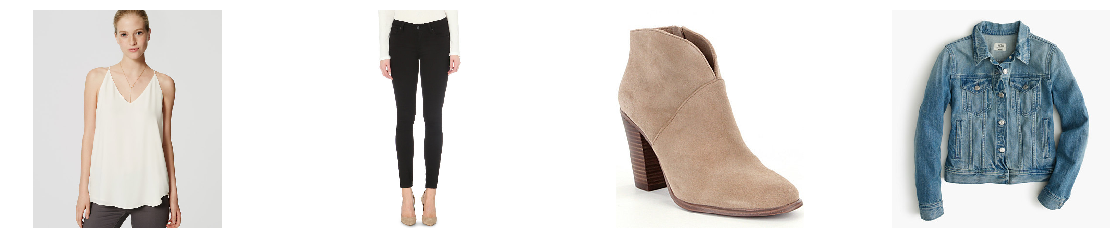

[[ 0.37862155  2.76680779  0.33897766 ...,  3.64167643  1.05156541
   1.90483594]]
Input & Output Products: ['627068303', '643013917', '630769557', '537849963']


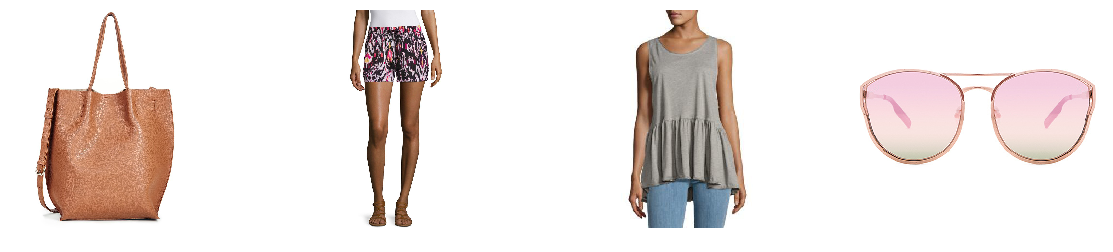

[[ 0.36516246  3.32689977  0.38370866 ...,  4.5389204   1.39931095
   2.36915064]]
Input & Output Products: ['613147896', '631644534', '630037096', '625941826']


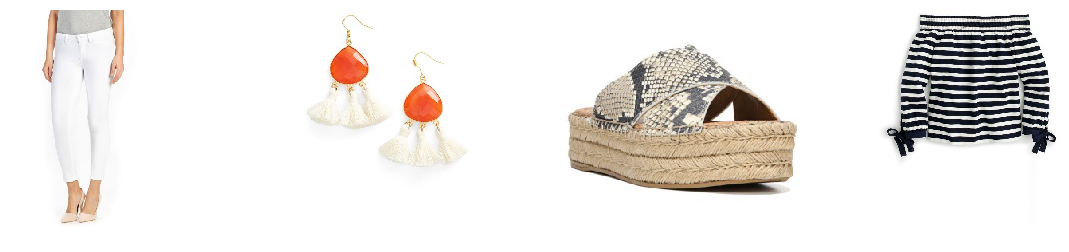

[[ 0.30856469  2.54417968  0.32218599 ...,  3.37984204  0.97214377
   1.80117786]]
Input & Output Products: ['535140410', '485706998', '610076917', '481130735']


KeyboardInterrupt: 

In [62]:
def get_closest_product_ids(input_features, model, index_to_prod_mapping):
    product_indexes = model.kneighbors(input_features, 15, return_distance=False)
    return [index_to_prod_mapping[index] for index in product_indexes[0]]

def test_predictions():
    test_file = 'data-outfits/outfit_permutations_sample.tsv'
    with open(test_file, 'r') as f:
        for line in f:
            l = line.split()
            product1_id = l[2]
            product2_id = l[5]
            product3_id = l[8]
            product4_id = l[11]
            product_ids = [product1_id, product2_id, product3_id, product4_id]
            merged_feat, y_feat = make_product_X_y(prods_to_feats, product1_id, product2_id, 
                                                   product3_id, product4_id)
            
            clothing_skipgrams_model.predict(np.array([merged_feat_test]))
            
            print('Input & Output Products: {}'.format(product_ids))
            display_product_images(product_ids)
            prediction_vector = clothing_skipgrams_model.predict(np.array([merged_feat]))
            prediction_vector = prediction_vector[0]
            print(prediction_vector)
            closest_product_ids = get_closest_product_ids(prediction_vector, neighbors_model, index_to_prod)
            
            print('Closest products: {}'.format(closest_product_ids))
            display_product_images(closest_product_ids)
            
test_predictions()

In [ ]:
a = np.array([[1,2, 3]])
b = np.array([[4,5, 6]])
ab = np.concatenate((a, b, a), axis=1)